In [1]:
import gc
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

In [2]:
clients = pd.read_csv('./Data/clients.csv')
report_dates = pd.read_csv('./Data/report_dates.csv', parse_dates=['report_dt'])
clients = clients.merge(report_dates, how='left', on='report')
train = pd.read_csv('./Data/train.csv')

In [3]:
transactions = pd.read_csv('./Data/transactions.csv.zip', 
                           parse_dates=['transaction_dttm'], 
                           low_memory=False, compression='zip')
transactions = transactions.sort_values('transaction_dttm').reset_index(drop=True)

In [4]:
transactions = transactions.merge(clients, how='left', on='user_id')

In [5]:
transactions['trans_positive'] = np.where( transactions['transaction_amt']>0,transactions['transaction_amt'],np.nan)
transactions['trans_negative'] = np.where( transactions['transaction_amt']<0,
                                          np.abs(transactions['transaction_amt']),np.nan)
transactions['days_to_report'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.days

In [6]:
min_day_trans = transactions.groupby(['user_id'])[['days_to_report']].min().\
    rename(columns={"days_to_report":"min_day_trans"}).reset_index()
max_day_trans = transactions.groupby(['user_id'])[['days_to_report']].max().\
    rename(columns={"days_to_report":"max_day_trans"}).reset_index()
count_trans = transactions.groupby(['user_id'])[['days_to_report']].count().\
    rename(columns={"days_to_report":"count_trans"}).reset_index()
nunique_days = transactions.groupby('user_id')[['days_to_report']].nunique().\
    rename({'days_to_report': 'nunique_days'}, axis=1).reset_index()

In [7]:
transactions = transactions.merge(min_day_trans, how='left', on='user_id')

In [8]:
transactions['days_groups'] = 0
transactions.loc[transactions['days_to_report']<=transactions['min_day_trans']+10, 'days_groups'] = 10
transactions.loc[transactions['days_to_report']<=transactions['min_day_trans']+5, 'days_groups'] = 5
transactions.loc[transactions['days_to_report']==transactions['min_day_trans'], 'days_groups'] = 1

In [9]:
trans_days_groups = transactions[~transactions['days_groups'].isin([0])].pivot_table(
    index = 'user_id',
    values=['trans_positive', 'trans_negative'],
    columns=['days_groups'],
    aggfunc=['count','sum']
)
trans_days_groups.columns = [f'days_groups_{x[0]}_{x[1]}_{x[2]}' for x in trans_days_groups.columns]
trans_days_groups.reset_index(inplace=True)

In [10]:
trans_cur_groups = transactions.pivot_table(
    index = 'user_id',
    values=['trans_positive', 'trans_negative'],
    columns=['currency_rk'],
    aggfunc=['count','sum']
)
trans_cur_groups.columns = [f'cur_groups_{x[0]}_{x[1]}_{x[2]}' for x in trans_cur_groups.columns]
trans_cur_groups.reset_index(inplace=True)

In [11]:
mcc_days_groups = transactions[~transactions['days_groups'].isin([0])].pivot_table(
    index = 'user_id',
    values=['mcc_code'],
    columns=['days_groups'],
    aggfunc=["count",'nunique']
)
mcc_days_groups.columns = [f'days_groups_mcc_{x[0]}_{x[1]}_{x[2]}' for x in mcc_days_groups.columns]
mcc_days_groups.reset_index(inplace=True)

In [12]:
%%time
transactions['date'] = transactions['transaction_dttm'].dt.date.astype('datetime64[ns]')
interval_trans = transactions.groupby("user_id").agg({"date":"unique"}).explode("date").reset_index()
interval_trans["interval"]=interval_trans.groupby("user_id")["date"].diff()
interval_trans = interval_trans.dropna() 
interval_trans["interval"]=interval_trans["interval"].dt.days
interval_trans = interval_trans.groupby(["user_id"]).agg({"interval": ["last","max"]})
interval_trans.columns = [f'date_{x[0]}_{x[1]}' for x in interval_trans.columns]
interval_trans.reset_index(inplace=True)

CPU times: user 12.7 s, sys: 529 ms, total: 13.2 s
Wall time: 13.1 s


In [13]:
count_mcc_code = transactions.mcc_code.value_counts().to_frame().reset_index().\
rename(columns={"index":"mcc_code", "mcc_code":"count_mcc_code"})

count_mcc_code20000 = np.array(count_mcc_code[(count_mcc_code['count_mcc_code']>20000)&
                                             (count_mcc_code['count_mcc_code']<1000000)]['mcc_code'])

mcc_code_dumm20000 = pd.get_dummies(transactions[transactions['mcc_code'].isin(count_mcc_code20000)].\
                               set_index('user_id')['mcc_code'])
mcc_code_dumm20000.columns = [f'mcc_count_{x}' for x in mcc_code_dumm20000.columns]
mcc_code_dumm20000 = mcc_code_dumm20000.groupby(['user_id']).agg('sum').reset_index()

In [14]:
count_mcc_code10000 = np.array(count_mcc_code[count_mcc_code['count_mcc_code']>=1000000]['mcc_code'])
mcc_code_dumm10000 = transactions[transactions['mcc_code'].isin(count_mcc_code10000)][['user_id','mcc_code']]
mcc_code_dumm10000 = mcc_code_dumm10000.groupby(['user_id']).agg('count').reset_index().\
rename(columns={'mcc_code':'mcc_count_big'})

In [15]:
count_mcc_code10000 = np.array(count_mcc_code[count_mcc_code['count_mcc_code']<=20000]['mcc_code'])
mcc_code_dumm00001 = transactions[transactions['mcc_code'].isin(count_mcc_code10000)][['user_id','mcc_code']]
mcc_code_dumm00001 = mcc_code_dumm00001.groupby(['user_id']).agg('count').reset_index().\
rename(columns={'mcc_code':'mcc_count_small'})

In [16]:
percent_last = clients[['user_id']].copy()
for x in [3, 30, 60, 90]:
    prev = transactions[transactions['days_to_report'] > x + 100].groupby('user_id')['report_dt'].agg(['count']).\
    reset_index().rename({'count': f'num_transaction_before_{x}_days'}, axis=1)
    last = transactions[transactions['days_to_report'] <= x + 100].groupby('user_id')['report_dt'].agg(['count']).\
    reset_index().rename({'count': f'num_transaction_last_{x}_days'}, axis=1)

    percent_last = percent_last.merge(prev, how='left', on='user_id')
    percent_last = percent_last.merge(last, how='left', on='user_id')
    percent_last[f'num_transaction_last_{x}_days'].fillna(.000001, inplace=True)
    percent_last[f'num_transaction_before_{x}_days'].fillna(0.000001, inplace=True)
    
    percent_last[f'percent_last_{x}'] = (percent_last[f'num_transaction_last_{x}_days'] / \
    percent_last[f'num_transaction_before_{x}_days'])*100
    percent_last.drop(f'num_transaction_last_{x}_days', inplace=True, axis=1)
    percent_last.drop(f'num_transaction_before_{x}_days', inplace=True, axis=1)

In [17]:
gc.collect()

0

In [18]:
clients = pd.read_csv('./Data/clients.csv')
df = clients.merge(
    train, on="user_id", how="left").merge(
    min_day_trans, on="user_id", how="left").merge(
    max_day_trans, on="user_id", how="left").merge(
    count_trans, on="user_id", how="left").merge(
    nunique_days, on="user_id", how="left").merge(
    trans_days_groups, on="user_id", how="left").merge(
    trans_cur_groups, on="user_id", how="left").merge(
    mcc_days_groups, on="user_id", how="left").merge(
    mcc_code_dumm20000, on="user_id", how="left").merge(
    mcc_code_dumm10000, on="user_id", how="left").merge(
    mcc_code_dumm00001, on="user_id", how="left").merge(
    percent_last, on="user_id", how="left")
df['pl_days_trans']=(df['max_day_trans']-df['min_day_trans'])/df['nunique_days']
df['pl_count_trans']=df['count_trans']/df['nunique_days']

In [19]:
df

,user_id,report,employee_count_nm,bankemplstatus,customer_age,target,time,min_day_trans,max_day_trans,count_trans,...,mcc_count_108,mcc_count_155,mcc_count_big,mcc_count_small,percent_last_3,percent_last_30,percent_last_60,percent_last_90,pl_days_trans,pl_count_trans
0,3,2,ОТ 101 ДО 500,0,3,0.0,77.0,108,214,11,...,0.0,0.0,NaN,1.0,9.090909e-06,57.142857,120.000000,266.666667,13.250000,1.375000
1,9,1,БОЛЕЕ 1001,0,3,NaN,NaN,102,283,90,...,0.0,0.0,38.0,7.0,2.272727e+00,13.924051,50.000000,83.673469,3.351852,1.666667
2,13,6,ОТ 501 ДО 1000,0,2,0.0,86.0,114,282,22,...,0.0,0.0,NaN,NaN,4.545455e-06,10.000000,29.411765,57.142857,9.333333,1.222222
3,37,5,БОЛЕЕ 1001,0,2,0.0,89.0,104,283,315,...,0.0,1.0,226.0,7.0,3.174603e-07,15.384615,55.940594,125.000000,1.376923,2.423077
4,41,1,ОТ 101 ДО 500,0,2,0.0,57.0,103,256,16,...,0.0,0.0,2.0,5.0,6.666667e+00,14.285714,60.000000,128.571429,12.750000,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,NaN,0,2,0.0,75.0,142,266,37,...,0.0,0.0,19.0,1.0,2.702703e-06,0.000003,2.777778,2.777778,5.391304,1.608696
95996,562205,12,NaN,0,1,NaN,NaN,102,280,151,...,0.0,3.0,35.0,14.0,2.721088e+00,16.153846,51.000000,122.058824,2.119048,1.797619
95997,562312,12,NaN,0,0,0.0,91.0,122,280,56,...,0.0,17.0,27.0,NaN,1.785714e-06,9.803922,36.585366,36.585366,4.157895,1.473684
95998,562721,12,NaN,0,2,0.0,29.0,105,280,85,...,0.0,0.0,18.0,NaN,1.176471e-06,2.409639,23.188406,46.551724,3.181818,1.545455


In [20]:
df.replace({'employee_count_nm':{'ОТ 101 ДО 500':1,'БОЛЕЕ 1001':2,'ОТ 501 ДО 1000':3,'ДО 10':4,
                                      'ОТ 11 ДО 50':5,'ОТ 51 ДО 100':6,'БОЛЕЕ 500':7,'ОТ 11 ДО 30':8,
                                      'ОТ 31 ДО 50':9}}, inplace=True)

In [21]:
df['label'] = np.where(df['target']==0, -df['time'], df['time'])
df['time'] = df['time'].fillna(-1)
df['time'] = df['time'].astype(np.int32)
df['target'] = df['target'].fillna(-1)
df['target'] = df['target'].astype(np.int8)

In [22]:
# df = df.fillna(0)

In [23]:
train_columns = [col for col in df.columns if col not in ['user_id', 'report_dt', 'label', 'target', 
                                                          'time', 'count_trans']]

In [24]:
df_train = df[(df['time']!=-1)].copy()
X_train, X_test, y_train, y_test = train_test_split(df_train[train_columns], df_train[['label','time','target']], 
                                                    stratify=df_train['report'], test_size=0.2, random_state=1234)

In [25]:
# Параметры неоптимизированные! 
xgb_model = xgb.XGBRegressor(objective="survival:cox",
                              random_state=458,
                              reg_lambda=1.5,
                              reg_alpha=1.4,
                              subsample=.8,
                              colsample_bytree=.3,
                              gamma=3,
                              min_child_weight=16,
                              max_depth=6,
                              learning_rate=0.005,
                              tree_method = "hist",
                              n_estimators=5000)
xgb_model.fit(X_train, y_train[['label']], early_stopping_rounds=200, 
              eval_set=[(X_test, y_test[['label']])], verbose=1)

[0]	validation_0-cox-nloglik:9.26805
[1]	validation_0-cox-nloglik:9.26599
[2]	validation_0-cox-nloglik:9.26225
[3]	validation_0-cox-nloglik:9.25811
[4]	validation_0-cox-nloglik:9.25595
[5]	validation_0-cox-nloglik:9.25403
[6]	validation_0-cox-nloglik:9.25022
[7]	validation_0-cox-nloglik:9.24872
[8]	validation_0-cox-nloglik:9.24519
[9]	validation_0-cox-nloglik:9.24148


/home/vlad/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-cox-nloglik:9.23951
[11]	validation_0-cox-nloglik:9.23802
[12]	validation_0-cox-nloglik:9.23523
[13]	validation_0-cox-nloglik:9.23075
[14]	validation_0-cox-nloglik:9.22810
[15]	validation_0-cox-nloglik:9.22519
[16]	validation_0-cox-nloglik:9.22047
[17]	validation_0-cox-nloglik:9.21743
[18]	validation_0-cox-nloglik:9.21503
[19]	validation_0-cox-nloglik:9.21118
[20]	validation_0-cox-nloglik:9.20919
[21]	validation_0-cox-nloglik:9.20723
[22]	validation_0-cox-nloglik:9.20440
[23]	validation_0-cox-nloglik:9.20211
[24]	validation_0-cox-nloglik:9.19921
[25]	validation_0-cox-nloglik:9.19727
[26]	validation_0-cox-nloglik:9.19286
[27]	validation_0-cox-nloglik:9.18992
[28]	validation_0-cox-nloglik:9.18793
[29]	validation_0-cox-nloglik:9.18325
[30]	validation_0-cox-nloglik:9.17926
[31]	validation_0-cox-nloglik:9.17598
[32]	validation_0-cox-nloglik:9.17310
[33]	validation_0-cox-nloglik:9.16964
[34]	validation_0-cox-nloglik:9.16603
[35]	validation_0-cox-nloglik:9.16222
[36]	validat

[223]	validation_0-cox-nloglik:8.87720
[224]	validation_0-cox-nloglik:8.87647
[225]	validation_0-cox-nloglik:8.87594
[226]	validation_0-cox-nloglik:8.87494
[227]	validation_0-cox-nloglik:8.87410
[228]	validation_0-cox-nloglik:8.87304
[229]	validation_0-cox-nloglik:8.87236
[230]	validation_0-cox-nloglik:8.87179
[231]	validation_0-cox-nloglik:8.87112
[232]	validation_0-cox-nloglik:8.87033
[233]	validation_0-cox-nloglik:8.86960
[234]	validation_0-cox-nloglik:8.86893
[235]	validation_0-cox-nloglik:8.86856
[236]	validation_0-cox-nloglik:8.86769
[237]	validation_0-cox-nloglik:8.86712
[238]	validation_0-cox-nloglik:8.86665
[239]	validation_0-cox-nloglik:8.86586
[240]	validation_0-cox-nloglik:8.86497
[241]	validation_0-cox-nloglik:8.86399
[242]	validation_0-cox-nloglik:8.86355
[243]	validation_0-cox-nloglik:8.86261
[244]	validation_0-cox-nloglik:8.86197
[245]	validation_0-cox-nloglik:8.86099
[246]	validation_0-cox-nloglik:8.86035
[247]	validation_0-cox-nloglik:8.85952
[248]	validation_0-cox-nl

[434]	validation_0-cox-nloglik:8.76948
[435]	validation_0-cox-nloglik:8.76913
[436]	validation_0-cox-nloglik:8.76870
[437]	validation_0-cox-nloglik:8.76841
[438]	validation_0-cox-nloglik:8.76815
[439]	validation_0-cox-nloglik:8.76787
[440]	validation_0-cox-nloglik:8.76763
[441]	validation_0-cox-nloglik:8.76718
[442]	validation_0-cox-nloglik:8.76678
[443]	validation_0-cox-nloglik:8.76643
[444]	validation_0-cox-nloglik:8.76613
[445]	validation_0-cox-nloglik:8.76585
[446]	validation_0-cox-nloglik:8.76545
[447]	validation_0-cox-nloglik:8.76511
[448]	validation_0-cox-nloglik:8.76487
[449]	validation_0-cox-nloglik:8.76460
[450]	validation_0-cox-nloglik:8.76425
[451]	validation_0-cox-nloglik:8.76393
[452]	validation_0-cox-nloglik:8.76366
[453]	validation_0-cox-nloglik:8.76331
[454]	validation_0-cox-nloglik:8.76313
[455]	validation_0-cox-nloglik:8.76291
[456]	validation_0-cox-nloglik:8.76250
[457]	validation_0-cox-nloglik:8.76232
[458]	validation_0-cox-nloglik:8.76210
[459]	validation_0-cox-nl

[645]	validation_0-cox-nloglik:8.72253
[646]	validation_0-cox-nloglik:8.72237
[647]	validation_0-cox-nloglik:8.72226
[648]	validation_0-cox-nloglik:8.72212
[649]	validation_0-cox-nloglik:8.72200
[650]	validation_0-cox-nloglik:8.72180
[651]	validation_0-cox-nloglik:8.72162
[652]	validation_0-cox-nloglik:8.72144
[653]	validation_0-cox-nloglik:8.72132
[654]	validation_0-cox-nloglik:8.72120
[655]	validation_0-cox-nloglik:8.72104
[656]	validation_0-cox-nloglik:8.72094
[657]	validation_0-cox-nloglik:8.72089
[658]	validation_0-cox-nloglik:8.72070
[659]	validation_0-cox-nloglik:8.72059
[660]	validation_0-cox-nloglik:8.72034
[661]	validation_0-cox-nloglik:8.72026
[662]	validation_0-cox-nloglik:8.72013
[663]	validation_0-cox-nloglik:8.72001
[664]	validation_0-cox-nloglik:8.71985
[665]	validation_0-cox-nloglik:8.71968
[666]	validation_0-cox-nloglik:8.71947
[667]	validation_0-cox-nloglik:8.71934
[668]	validation_0-cox-nloglik:8.71911
[669]	validation_0-cox-nloglik:8.71892
[670]	validation_0-cox-nl

[856]	validation_0-cox-nloglik:8.70005
[857]	validation_0-cox-nloglik:8.70004
[858]	validation_0-cox-nloglik:8.70000
[859]	validation_0-cox-nloglik:8.69994
[860]	validation_0-cox-nloglik:8.69996
[861]	validation_0-cox-nloglik:8.69986
[862]	validation_0-cox-nloglik:8.69980
[863]	validation_0-cox-nloglik:8.69972
[864]	validation_0-cox-nloglik:8.69960
[865]	validation_0-cox-nloglik:8.69957
[866]	validation_0-cox-nloglik:8.69943
[867]	validation_0-cox-nloglik:8.69941
[868]	validation_0-cox-nloglik:8.69940
[869]	validation_0-cox-nloglik:8.69932
[870]	validation_0-cox-nloglik:8.69921
[871]	validation_0-cox-nloglik:8.69904
[872]	validation_0-cox-nloglik:8.69899
[873]	validation_0-cox-nloglik:8.69889
[874]	validation_0-cox-nloglik:8.69875
[875]	validation_0-cox-nloglik:8.69867
[876]	validation_0-cox-nloglik:8.69855
[877]	validation_0-cox-nloglik:8.69844
[878]	validation_0-cox-nloglik:8.69834
[879]	validation_0-cox-nloglik:8.69823
[880]	validation_0-cox-nloglik:8.69818
[881]	validation_0-cox-nl

[1065]	validation_0-cox-nloglik:8.68847
[1066]	validation_0-cox-nloglik:8.68850
[1067]	validation_0-cox-nloglik:8.68845
[1068]	validation_0-cox-nloglik:8.68837
[1069]	validation_0-cox-nloglik:8.68831
[1070]	validation_0-cox-nloglik:8.68827
[1071]	validation_0-cox-nloglik:8.68823
[1072]	validation_0-cox-nloglik:8.68822
[1073]	validation_0-cox-nloglik:8.68822
[1074]	validation_0-cox-nloglik:8.68815
[1075]	validation_0-cox-nloglik:8.68810
[1076]	validation_0-cox-nloglik:8.68809
[1077]	validation_0-cox-nloglik:8.68809
[1078]	validation_0-cox-nloglik:8.68810
[1079]	validation_0-cox-nloglik:8.68803
[1080]	validation_0-cox-nloglik:8.68800
[1081]	validation_0-cox-nloglik:8.68790
[1082]	validation_0-cox-nloglik:8.68790
[1083]	validation_0-cox-nloglik:8.68780
[1084]	validation_0-cox-nloglik:8.68775
[1085]	validation_0-cox-nloglik:8.68773
[1086]	validation_0-cox-nloglik:8.68765
[1087]	validation_0-cox-nloglik:8.68762
[1088]	validation_0-cox-nloglik:8.68755
[1089]	validation_0-cox-nloglik:8.68750


[1270]	validation_0-cox-nloglik:8.68154
[1271]	validation_0-cox-nloglik:8.68153
[1272]	validation_0-cox-nloglik:8.68138
[1273]	validation_0-cox-nloglik:8.68133
[1274]	validation_0-cox-nloglik:8.68133
[1275]	validation_0-cox-nloglik:8.68128
[1276]	validation_0-cox-nloglik:8.68123
[1277]	validation_0-cox-nloglik:8.68118
[1278]	validation_0-cox-nloglik:8.68115
[1279]	validation_0-cox-nloglik:8.68110
[1280]	validation_0-cox-nloglik:8.68112
[1281]	validation_0-cox-nloglik:8.68108
[1282]	validation_0-cox-nloglik:8.68108
[1283]	validation_0-cox-nloglik:8.68102
[1284]	validation_0-cox-nloglik:8.68102
[1285]	validation_0-cox-nloglik:8.68102
[1286]	validation_0-cox-nloglik:8.68102
[1287]	validation_0-cox-nloglik:8.68099
[1288]	validation_0-cox-nloglik:8.68093
[1289]	validation_0-cox-nloglik:8.68092
[1290]	validation_0-cox-nloglik:8.68090
[1291]	validation_0-cox-nloglik:8.68090
[1292]	validation_0-cox-nloglik:8.68087
[1293]	validation_0-cox-nloglik:8.68079
[1294]	validation_0-cox-nloglik:8.68081


[1475]	validation_0-cox-nloglik:8.67725
[1476]	validation_0-cox-nloglik:8.67725
[1477]	validation_0-cox-nloglik:8.67724
[1478]	validation_0-cox-nloglik:8.67725
[1479]	validation_0-cox-nloglik:8.67722
[1480]	validation_0-cox-nloglik:8.67723
[1481]	validation_0-cox-nloglik:8.67722
[1482]	validation_0-cox-nloglik:8.67720
[1483]	validation_0-cox-nloglik:8.67716
[1484]	validation_0-cox-nloglik:8.67712
[1485]	validation_0-cox-nloglik:8.67712
[1486]	validation_0-cox-nloglik:8.67706
[1487]	validation_0-cox-nloglik:8.67702
[1488]	validation_0-cox-nloglik:8.67699
[1489]	validation_0-cox-nloglik:8.67697
[1490]	validation_0-cox-nloglik:8.67698
[1491]	validation_0-cox-nloglik:8.67699
[1492]	validation_0-cox-nloglik:8.67698
[1493]	validation_0-cox-nloglik:8.67699
[1494]	validation_0-cox-nloglik:8.67695
[1495]	validation_0-cox-nloglik:8.67695
[1496]	validation_0-cox-nloglik:8.67690
[1497]	validation_0-cox-nloglik:8.67690
[1498]	validation_0-cox-nloglik:8.67688
[1499]	validation_0-cox-nloglik:8.67687


[1680]	validation_0-cox-nloglik:8.67468
[1681]	validation_0-cox-nloglik:8.67466
[1682]	validation_0-cox-nloglik:8.67468
[1683]	validation_0-cox-nloglik:8.67467
[1684]	validation_0-cox-nloglik:8.67465
[1685]	validation_0-cox-nloglik:8.67466
[1686]	validation_0-cox-nloglik:8.67466
[1687]	validation_0-cox-nloglik:8.67469
[1688]	validation_0-cox-nloglik:8.67459
[1689]	validation_0-cox-nloglik:8.67459
[1690]	validation_0-cox-nloglik:8.67458
[1691]	validation_0-cox-nloglik:8.67461
[1692]	validation_0-cox-nloglik:8.67460
[1693]	validation_0-cox-nloglik:8.67452
[1694]	validation_0-cox-nloglik:8.67455
[1695]	validation_0-cox-nloglik:8.67456
[1696]	validation_0-cox-nloglik:8.67453
[1697]	validation_0-cox-nloglik:8.67446
[1698]	validation_0-cox-nloglik:8.67446
[1699]	validation_0-cox-nloglik:8.67444
[1700]	validation_0-cox-nloglik:8.67443
[1701]	validation_0-cox-nloglik:8.67444
[1702]	validation_0-cox-nloglik:8.67441
[1703]	validation_0-cox-nloglik:8.67442
[1704]	validation_0-cox-nloglik:8.67441


[1885]	validation_0-cox-nloglik:8.67385
[1886]	validation_0-cox-nloglik:8.67386
[1887]	validation_0-cox-nloglik:8.67386
[1888]	validation_0-cox-nloglik:8.67382
[1889]	validation_0-cox-nloglik:8.67385
[1890]	validation_0-cox-nloglik:8.67386
[1891]	validation_0-cox-nloglik:8.67382
[1892]	validation_0-cox-nloglik:8.67380
[1893]	validation_0-cox-nloglik:8.67380
[1894]	validation_0-cox-nloglik:8.67381
[1895]	validation_0-cox-nloglik:8.67381
[1896]	validation_0-cox-nloglik:8.67381
[1897]	validation_0-cox-nloglik:8.67381
[1898]	validation_0-cox-nloglik:8.67378
[1899]	validation_0-cox-nloglik:8.67378
[1900]	validation_0-cox-nloglik:8.67380
[1901]	validation_0-cox-nloglik:8.67376
[1902]	validation_0-cox-nloglik:8.67375
[1903]	validation_0-cox-nloglik:8.67372
[1904]	validation_0-cox-nloglik:8.67372
[1905]	validation_0-cox-nloglik:8.67372
[1906]	validation_0-cox-nloglik:8.67367
[1907]	validation_0-cox-nloglik:8.67362
[1908]	validation_0-cox-nloglik:8.67363
[1909]	validation_0-cox-nloglik:8.67363


[2090]	validation_0-cox-nloglik:8.67301
[2091]	validation_0-cox-nloglik:8.67301
[2092]	validation_0-cox-nloglik:8.67302
[2093]	validation_0-cox-nloglik:8.67304
[2094]	validation_0-cox-nloglik:8.67304
[2095]	validation_0-cox-nloglik:8.67302
[2096]	validation_0-cox-nloglik:8.67301
[2097]	validation_0-cox-nloglik:8.67301
[2098]	validation_0-cox-nloglik:8.67301
[2099]	validation_0-cox-nloglik:8.67299
[2100]	validation_0-cox-nloglik:8.67299
[2101]	validation_0-cox-nloglik:8.67299
[2102]	validation_0-cox-nloglik:8.67304
[2103]	validation_0-cox-nloglik:8.67301
[2104]	validation_0-cox-nloglik:8.67300
[2105]	validation_0-cox-nloglik:8.67300
[2106]	validation_0-cox-nloglik:8.67300
[2107]	validation_0-cox-nloglik:8.67300
[2108]	validation_0-cox-nloglik:8.67299
[2109]	validation_0-cox-nloglik:8.67299
[2110]	validation_0-cox-nloglik:8.67300
[2111]	validation_0-cox-nloglik:8.67300
[2112]	validation_0-cox-nloglik:8.67300
[2113]	validation_0-cox-nloglik:8.67298
[2114]	validation_0-cox-nloglik:8.67298


[2295]	validation_0-cox-nloglik:8.67288
[2296]	validation_0-cox-nloglik:8.67285
[2297]	validation_0-cox-nloglik:8.67290
[2298]	validation_0-cox-nloglik:8.67288
[2299]	validation_0-cox-nloglik:8.67287
[2300]	validation_0-cox-nloglik:8.67287
[2301]	validation_0-cox-nloglik:8.67287
[2302]	validation_0-cox-nloglik:8.67287
[2303]	validation_0-cox-nloglik:8.67290
[2304]	validation_0-cox-nloglik:8.67290
[2305]	validation_0-cox-nloglik:8.67290
[2306]	validation_0-cox-nloglik:8.67290
[2307]	validation_0-cox-nloglik:8.67290
[2308]	validation_0-cox-nloglik:8.67290
[2309]	validation_0-cox-nloglik:8.67288
[2310]	validation_0-cox-nloglik:8.67289
[2311]	validation_0-cox-nloglik:8.67289
[2312]	validation_0-cox-nloglik:8.67289
[2313]	validation_0-cox-nloglik:8.67290
[2314]	validation_0-cox-nloglik:8.67289
[2315]	validation_0-cox-nloglik:8.67283
[2316]	validation_0-cox-nloglik:8.67284
[2317]	validation_0-cox-nloglik:8.67286
[2318]	validation_0-cox-nloglik:8.67286
[2319]	validation_0-cox-nloglik:8.67294


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=16, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, objective='survival:cox', ...)

In [26]:
xgb_model.best_iteration

2174

In [27]:
predictions_xgb = xgb_model.predict(X_train)
concordance_index(y_train.time, -predictions_xgb, y_train.target)

0.8393340339300565

In [28]:
# 0.8185496099440384

In [29]:
predictions_xgb = xgb_model.predict(X_test)
concordance_index(y_test.time, -predictions_xgb, y_test.target)

0.7808693057515477

In [30]:
# 0.7804483951235

In [31]:
df_imp = pd.DataFrame(list(X_train), xgb_model.feature_importances_)
df_imp.columns = ["Feature_Names"]
df_imp["Importances"] = df_imp.index
df_imp = df_imp.sort_values(by = "Importances", ascending = False)
df_imp.index = np.arange(0,len(df_imp))
df_imp.head(30)

,Feature_Names,Importances
0,mcc_count_51,0.096461
1,employee_count_nm,0.066879
2,customer_age,0.062597
3,cur_groups_count_trans_negative_0,0.025076
4,mcc_count_15,0.021041
5,min_day_trans,0.019379
6,cur_groups_sum_trans_negative_1,0.017159
7,mcc_count_155,0.016112
8,percent_last_30,0.014488
9,cur_groups_sum_trans_positive_0,0.013857


In [32]:
X_pred = df[df['time']==-1][train_columns].copy()
predictions = xgb_model.predict(X_pred)
submit = df[df['time']==-1][['user_id']].copy()
submit['predict'] = predictions
submit.to_csv(f'submission_x.csv',index=False)
submit

,user_id,predict
1,9,0.324460
9,61,0.312490
10,62,0.875848
17,80,0.160564
20,88,2.011712
...,...,...
95988,561362,1.032874
95990,561419,1.038199
95993,561895,0.834000
95994,561908,1.139176


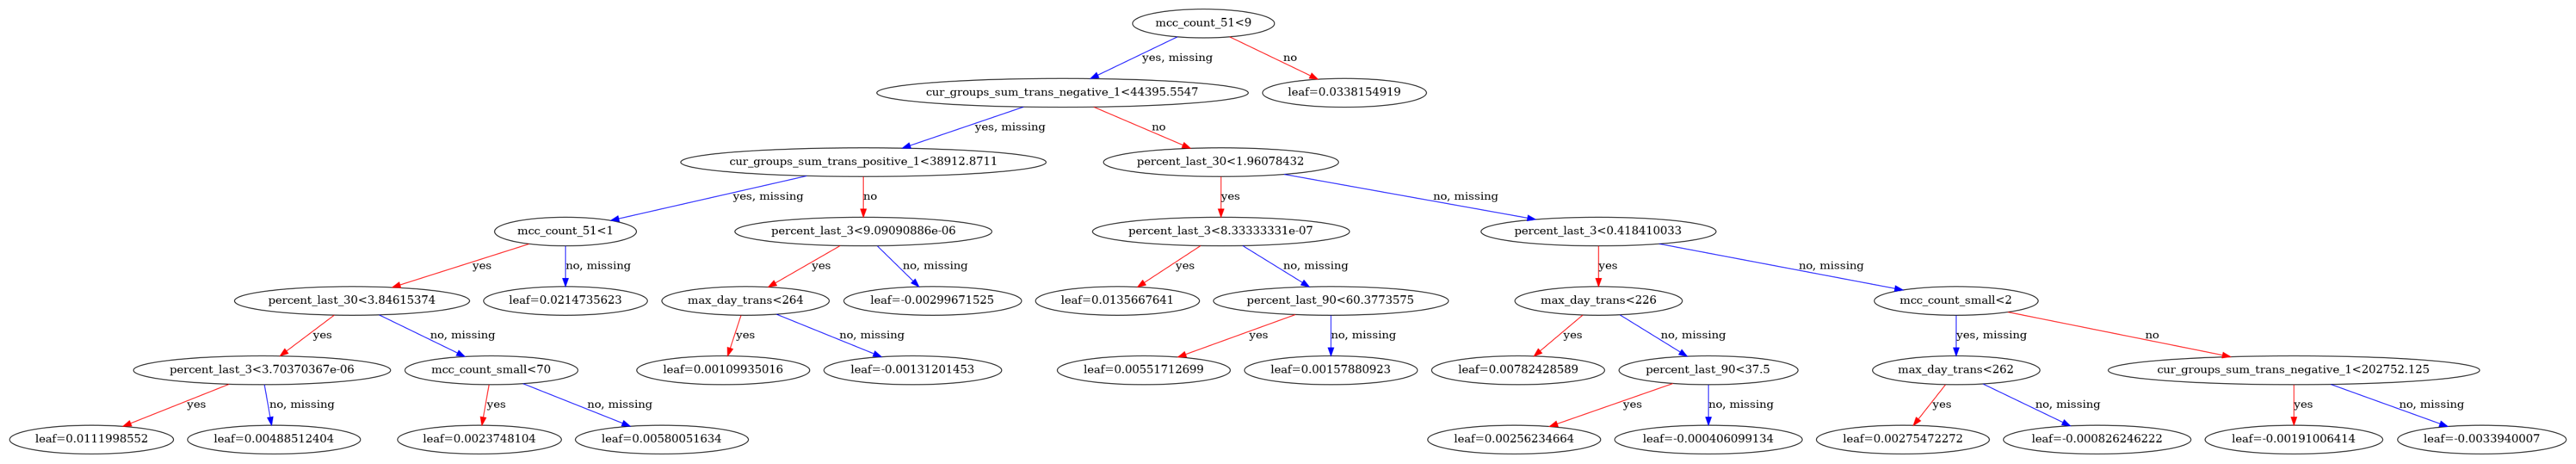

In [33]:
fig, ax = plt.subplots(figsize=(50, 60))
xgb.plot_tree(xgb_model, num_trees=3, ax=ax)
plt.show()